# Sentiment Classification for IMDB Movie Reviews


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

## Loading the Data

You will need to load the reviews. These are provided in the zip.
In addition, you will use pretrained embeddings (GloVe, 100d) which you need to download e.g. from https://nlp.stanford.edu/projects/glove/ .

In [2]:
movie_reviews = pd.read_csv("../data/imdb_data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [3]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

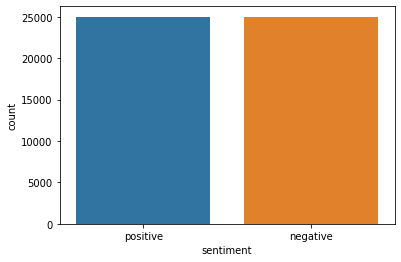

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)


## Preprocessing

__Prepare the review content__:

Remove 
* html tags
* replace punctuation with a space
* remove single characters
* remove multiple spaces

Split into train/test.

Tokenize the reviews - i.e. mapping the words to integers by using a vocabulary of the most frequent words.

Cut and pad the sequences to a given fixed length.

In [6]:
num_words = 5000
maxlen = 100

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now the above sample review looks as follows - e.g. in teh first sentence, "there's a zombie" is replaced by just "there a zombie"

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

__Prepare the labels__

In [11]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

__Split into train/test__

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

__Tokenize__

In [13]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer has found %i words. When transforming texts to sequences words that have an index above %i are just ignored."%(vocab_size, num_words))

Tokenizer has found 92547 words. When transforming texts to sequences words that have an index above 5000 are just ignored.


In [15]:
indices = [0,1,2,3,4,5,6,4999,5000,10000]
for word, index in tokenizer.word_index.items():
    if index in indices:
        print("%s : %i"%(word,index))

the : 1
and : 2
of : 3
to : 4
is : 5
it : 6
secretly : 4999
joins : 5000
shattering : 10000


In [16]:
tokenizer.texts_to_sequences(["This is %s."%tokenizer.index_word[10000]])

[[8, 5]]

__Cutting and Padding__

In [17]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Utility

In [18]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [19]:
import sklearn
import pandas as pd
activities = ["neg", "pos"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.round(scores)
    labels = Y_test
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## A First Simple Model: Just an embedding layer and a dense layer 

In [33]:
X_train.shape

(40000, 100)

In [20]:
y_train

array([0, 0, 1, ..., 0, 1, 1])

In [39]:
# START YOUR CODE

nepochs = 20
embedding_dim = 100
batchsize = 32

model = Sequential([
    Embedding(5000, output_dim=128, input_length=100),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# END YOUR CODE

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 128)          640000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 12801     
Total params: 652,801
Trainable params: 652,801
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 9s 237us/sample - loss: 0.3973 - accuracy: 0.8161 - val_loss: 0.3151 - val_accuracy: 0.8616
Epoch 2/20
40000/40000 [==============================] - 9s 225us/sample - loss: 0.2078 - accuracy: 0.9219 - val_loss: 0.3362 - val_accuracy: 0.8562
Epoch 3/20
40000/40000 [==============================] - 9s 228us/sample - loss: 0.0612 - accuracy: 0.9890 - val_loss: 0.3852 - val_accuracy: 0.8492
Epoch 4/20
40000/40000 [==============================] - 9s 226us/sample - loss: 0.0141 - accuracy: 0.9994 - val_loss: 0.4373 - val_accuracy: 0.8494
Epoch 5/20
40000/40000 [==============================] - 9s 228us/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.4836 - val_accuracy: 0.8518
Epoch 6/20
40000/40000 [==============================] - 9s 227us/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5273 - val_accuracy: 0.8519
Epoch 7/20
40000/40000 [==========================

Train accuracy (end): 1.0
Train accuracy (max): 1.0
Test accuracy (end) : 0.8517
Test accuracy (max) : 0.8616


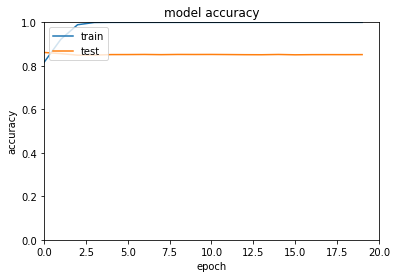

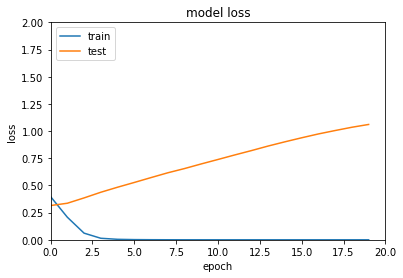

,neg,pos
neg,4194,767
pos,716,4323


In [41]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We easily get into the overfitting regime since we have a huge amount of parameters.

## Using GloVe as pretrained embedding

In [42]:
embeddings_dictionary = dict()
glove_path = '../data/glove.6B.100d.txt'
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [43]:
embedding_matrix = np.zeros((num_words, maxlen))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index<num_words:
        embedding_matrix[index] = embedding_vector

In [45]:
num_words

5000

In [56]:
embedding_matrix.shape

(5000, 100)

In [61]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.39859   , -0.14019001,  1.43739998, ...,  0.45267999,
         0.089081  , -0.88445002],
       [-0.46392   ,  0.59390002,  0.11265   , ..., -0.33919999,
         0.29409   ,  0.3434    ],
       [ 0.74285001, -0.26137999,  0.13079999, ..., -0.23864999,
        -0.16433001, -0.15829   ]])

In [70]:
# START YOUR CODE
nepochs = 20
embedding_dim = embedding_matrix.shape[1]
batchsize = 32
embedding_layer = Embedding(embedding_matrix.shape[0], embedding_dim, 
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=100,
                           trainable=False)

model = Sequential([
    embedding_layer,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
flatten_21 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 10001     
Total params: 510,001
Trainable params: 10,001
Non-trainable params: 500,000
_________________________________________________________________
None


In [71]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 4s 104us/sample - loss: 0.5865 - accuracy: 0.6961 - val_loss: 0.5342 - val_accuracy: 0.7391
Epoch 2/20
40000/40000 [==============================] - 4s 92us/sample - loss: 0.5013 - accuracy: 0.7591 - val_loss: 0.5613 - val_accuracy: 0.7341
Epoch 3/20
40000/40000 [==============================] - 4s 91us/sample - loss: 0.4747 - accuracy: 0.7790 - val_loss: 0.6174 - val_accuracy: 0.7216
Epoch 4/20
40000/40000 [==============================] - 4s 90us/sample - loss: 0.4557 - accuracy: 0.7896 - val_loss: 0.5678 - val_accuracy: 0.7405
Epoch 5/20
40000/40000 [==============================] - 4s 89us/sample - loss: 0.4399 - accuracy: 0.7982 - val_loss: 0.5903 - val_accuracy: 0.7311
Epoch 6/20
40000/40000 [==============================] - 4s 92us/sample - loss: 0.4373 - accuracy: 0.8009 - val_loss: 0.6164 - val_accuracy: 0.7355
Epoch 7/20
40000/40000 [==============================]

Train accuracy (end): 0.8221
Train accuracy (max): 0.826025
Test accuracy (end) : 0.7176
Test accuracy (max) : 0.7405


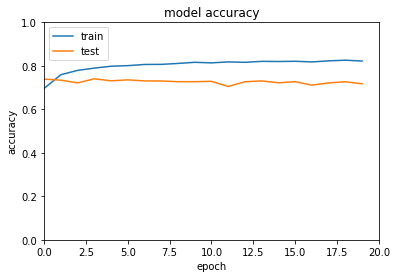

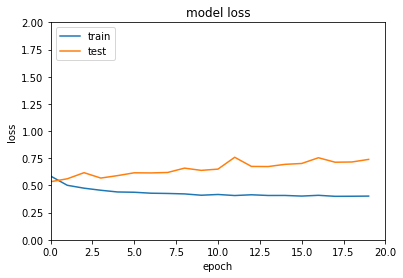

,neg,pos
neg,3230,1731
pos,1093,3946


In [72]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

## Further Model / Hyper Parameter Combinations

Examples:

* Pretrained embedding (with GloVe), possibly fine-tuned
* dito + (SimpleRNN | LSTM | GRU | Conv1D)
* dito + stacked layers

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


In [102]:
stacked_lstm = Sequential([
    embedding_layer,
    LSTM(128, return_sequences=True),
    LSTM(256, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
nepochs=10
stacked_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# START YOUR CODE

print(stacked_lstm.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 128)          117248    
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 256)          394240    
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                82176     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 1,093,729
Trainable params: 593,729
Non-trainable params: 500,000
_________________________________________________________________
None


In [103]:
history = stacked_lstm.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 43s 1ms/sample - loss: 0.5434 - accuracy: 0.7086 - val_loss: 0.4137 - val_accuracy: 0.8069
Epoch 2/10
40000/40000 [==============================] - 39s 963us/sample - loss: 0.4032 - accuracy: 0.8166 - val_loss: 0.4197 - val_accuracy: 0.8014
Epoch 3/10
40000/40000 [==============================] - 38s 956us/sample - loss: 0.3863 - accuracy: 0.8249 - val_loss: 0.3723 - val_accuracy: 0.8298
Epoch 4/10
40000/40000 [==============================] - 38s 960us/sample - loss: 0.3482 - accuracy: 0.8461 - val_loss: 0.3783 - val_accuracy: 0.8349
Epoch 5/10
40000/40000 [==============================] - 38s 959us/sample - loss: 0.3386 - accuracy: 0.8513 - val_loss: 0.3276 - val_accuracy: 0.8533
Epoch 6/10
40000/40000 [==============================] - 38s 956us/sample - loss: 0.3067 - accuracy: 0.8675 - val_loss: 0.3222 - val_accuracy: 0.8574
Epoch 7/10
40000/40000 [======================

Train accuracy (end): 0.915875
Train accuracy (max): 0.915875
Test accuracy (end) : 0.8572
Test accuracy (max) : 0.8643


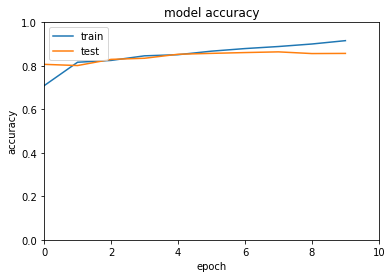

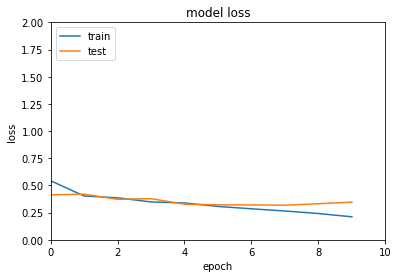

,neg,pos
neg,4195,766
pos,662,4377


In [104]:
performance_plots(stacked_lstm, X_test, y_test, history, nepochs)
confusion_matrix(stacked_lstm, X_test, y_test)

In [89]:
from tensorflow.keras.layers import GRU
stacked_gru = Sequential([
    embedding_layer,
    GRU(128, return_sequences=True),
    GRU(256, return_sequences=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

stacked_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# START YOUR CODE

print(stacked_gru.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 256)          296448    
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                61824     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 946,657
Trainable params: 446,657
Non-trainable params: 500,000
_________________________________________________________________
None


In [90]:
history = stacked_gru.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 37s 933us/sample - loss: 0.4462 - accuracy: 0.7854 - val_loss: 0.3706 - val_accuracy: 0.8293
Epoch 2/10
40000/40000 [==============================] - 33s 821us/sample - loss: 0.3531 - accuracy: 0.8442 - val_loss: 0.3297 - val_accuracy: 0.8549
Epoch 3/10
40000/40000 [==============================] - 33s 818us/sample - loss: 0.3117 - accuracy: 0.8650 - val_loss: 0.3301 - val_accuracy: 0.8572
Epoch 4/10
40000/40000 [==============================] - 33s 825us/sample - loss: 0.2781 - accuracy: 0.8818 - val_loss: 0.3148 - val_accuracy: 0.8672
Epoch 5/10
40000/40000 [==============================] - 33s 831us/sample - loss: 0.2412 - accuracy: 0.9007 - val_loss: 0.3217 - val_accuracy: 0.8591
Epoch 6/10
40000/40000 [==============================] - 33s 832us/sample - loss: 0.1975 - accuracy: 0.9221 - val_loss: 0.3395 - val_accuracy: 0.8590
Epoch 7/10
40000/40000 [====================

Train accuracy (end): 0.9789
Train accuracy (max): 0.9789
Test accuracy (end) : 0.8549
Test accuracy (max) : 0.8672


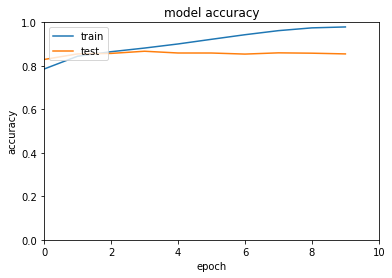

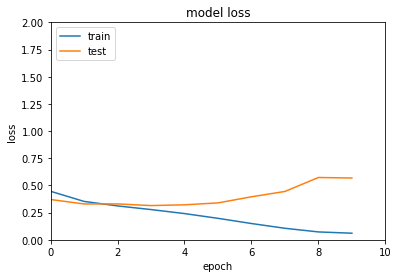

,neg,pos
neg,4250,711
pos,740,4299


In [91]:
performance_plots(stacked_gru, X_test, y_test, history, nepochs)
confusion_matrix(stacked_gru, X_test, y_test)

In [105]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
conv1d = Sequential([
    embedding_layer,
    Conv1D(256, kernel_size=7, activation='relu'),
#    GlobalMaxPooling1D(),
    Conv1D(128, kernel_size=5, activation='relu'),
#    GlobalMaxPooling1D(),
    Conv1D(64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
#    tf.keras.layers.Flatten(),
    Dense(1, activation='sigmoid')
])

nepochs=20
conv1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
conv1d.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 94, 256)           179456    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 90, 128)           163968    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 88, 64)            24640     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 868,129
Trainable params: 368,129
Non-trainable params: 500,000
_________________________________________

In [106]:
history = conv1d.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 12s 302us/sample - loss: 0.4844 - accuracy: 0.7585 - val_loss: 0.4253 - val_accuracy: 0.7999
Epoch 2/20
40000/40000 [==============================] - 11s 280us/sample - loss: 0.4060 - accuracy: 0.8119 - val_loss: 0.3956 - val_accuracy: 0.8207
Epoch 3/20
40000/40000 [==============================] - 11s 280us/sample - loss: 0.3691 - accuracy: 0.8338 - val_loss: 0.4097 - val_accuracy: 0.8096
Epoch 4/20
40000/40000 [==============================] - 11s 280us/sample - loss: 0.3364 - accuracy: 0.8512 - val_loss: 0.3942 - val_accuracy: 0.8182
Epoch 5/20
40000/40000 [==============================] - 11s 280us/sample - loss: 0.2966 - accuracy: 0.8724 - val_loss: 0.3958 - val_accuracy: 0.8239
Epoch 6/20
40000/40000 [==============================] - 11s 275us/sample - loss: 0.2544 - accuracy: 0.8910 - val_loss: 0.4329 - val_accuracy: 0.8173
Epoch 7/20
40000/40000 [====================

Train accuracy (end): 0.985875
Train accuracy (max): 0.985875
Test accuracy (end) : 0.8107
Test accuracy (max) : 0.8239


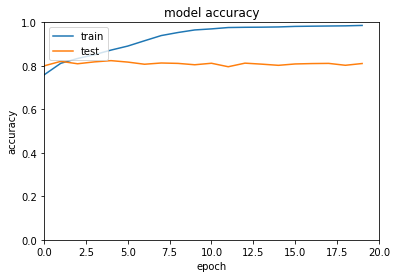

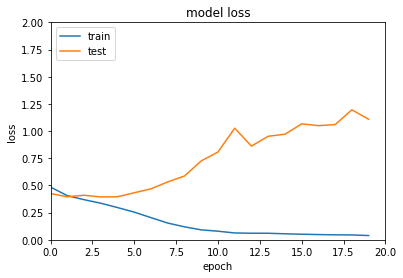

,neg,pos
neg,4184,777
pos,1116,3923


In [107]:
performance_plots(conv1d, X_test, y_test, history, nepochs)
confusion_matrix(conv1d, X_test, y_test)

## Report with your Findings

We compared Stacked LSTM, Stacked GRU and stacked Conv1D models here. Interestingly, the LSTM and GRU models seem to be approximately equivalent in regard to test accuracy. However the Conv1D model may suffer from too large overfitting as seen in the plot of the loss function.